# BUILDING A PERSONALIZED MOVIE RECOMMENDATION SYSTEM
---
COLLABORATIVE AND CONTENT-BASED FILTERING

## BUSINESS PROBLEM:
---


In today's digital world, users are overwhelmed with vast amounts of content, whether it's movies, products, music, or news articles. Businesses struggle to keep users engaged by providing personalized recommendations. Without an effective recommender system, customers may churn, engagement may decline, and businesses may lose revenue opportunities.


For example, in an online movie streaming platform, users need relevant and personalized movie recommendations based on their viewing history and preferences. A poor recommendation system may result in users struggling to find interesting content, leading to lower customer satisfaction and reduced subscription retention.

## OBJECTIVES
---


By implementing an effective recommender system, businesses can:

1. Increase user engagement and retention.

2. Improve customer satisfaction by offering relevant recommendations.

3. Enhance revenue opportunities through personalized marketing.



## GOALS
---

The goal of this study is to develop a personalized recommendation system that improves user experience and engagement by suggesting relevant content based on past interactions. This will be achieved using:

1. Collaborative Filtering: Predict user preferences based on similar users.

2. Content-Based Filtering: Recommend items similar to what a user has liked before.

3. Create a model and carry out a model evaluation

4. Performance Evaluation: Assess the effectiveness of different models using evaluation metrics such as RMSE (Root Mean Squared Error) and Cosine Similarity

## IMPORTING THE NECCESSRY LIBRARIES
---

*  Import necessary libraries for data handling, visualization, and modeling.



In [131]:
!pip install surprise

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn.metrics as metrics
import warnings
warnings.filterwarnings('ignore')

from itertools import chain
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from surprise.prediction_algorithms import knns
from surprise import Reader, Dataset, SVD, KNNBasic, accuracy
from surprise.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from surprise.model_selection import cross_validate

## LOADING THE DATASET
---
*   Read and explore the dataset.


In [132]:
# upload links datasets
links = pd.read_csv("links.csv")
print(links.shape)
# links.head(5)

#upload movies dataset
movies = pd.read_csv("movies.csv")
print(movies.shape)
# movies.head(5)

# upload ratings dataset
ratings = pd.read_csv("ratings.csv")
print(ratings.shape)
#ratings.head(5)


(9742, 3)
(9742, 3)
(100836, 4)


## DATA CLEANING

*   Merging the Datasets
*   Drop the irrelevant columns
*   Handle missing data.
*   Remove duplicate records, if any.
*   Clean or transform data types as necessary.

In [133]:
# Merge links and movies dataset using 'movieId'
links_movies = pd.merge(links, movies, on="movieId", how="inner")

# Now merge the result with ratings using 'movieId'
links_movies_ratings = pd.merge(links_movies, ratings, on="movieId", how="inner")

# Print shapes and display the first few rows
print(links_movies_ratings.shape)

# view the dataset
links_movies_ratings.head(5)

(100836, 8)


movieId  imdbId  tmdbId             title  \
0        1  114709   862.0  Toy Story (1995)   
1        1  114709   862.0  Toy Story (1995)   
2        1  114709   862.0  Toy Story (1995)   
3        1  114709   862.0  Toy Story (1995)   
4        1  114709   862.0  Toy Story (1995)   

                                        genres  userId  rating   timestamp  
0  Adventure|Animation|Children|Comedy|Fantasy       1     4.0   964982703  
1  Adventure|Animation|Children|Comedy|Fantasy       5     4.0   847434962  
2  Adventure|Animation|Children|Comedy|Fantasy       7     4.5  1106635946  
3  Adventure|Animation|Children|Comedy|Fantasy      15     2.5  1510577970  
4  Adventure|Animation|Children|Comedy|Fantasy      17     4.5  1305696483

In [134]:
# drop columns
links_movies_ratings.drop(["imdbId", "tmdbId", "timestamp"], axis=1, inplace=True)
links_movies_ratings.head(5)

movieId             title                                       genres  \
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
1        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
2        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
3        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
4        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   

   userId  rating  
0       1     4.0  
1       5     4.0  
2       7     4.5  
3      15     2.5  
4      17     4.5

In [135]:
# handle missing value
links_movies_ratings.dropna(inplace=True)
links_movies_ratings.isnull().sum()

movieId    0
title      0
genres     0
userId     0
rating     0
dtype: int64

In [120]:
print(links_movies_ratings.shape)

print("There are 100836 movies in the dataset")
print("There are 5 unique genre-related words in the dataset (after processing).")

(100836, 5)
There are 100836 movies in the dataset
There are 5 unique genre-related words in the dataset (after processing).


## DATA PREPROSSESSING

> This is conducted in order to transform raw data into a structured format suitable for machine learning models.

*   Extracting year from movie titles.
*   Converting Data into Model-Specific Format
*   Splitting Data for Training & Testing






In [121]:
# Extract year from movie title
links_movies_ratings['year'] = links_movies_ratings['title'].str.extract(r'\((\d{4})\)').astype(float)

# Remove the year from the title column
links_movies_ratings['title'] = links_movies_ratings['title'].str.replace(r'\s*\(\d{4}\)', '', regex=True)

# Display the updated dataframe
links_movies_ratings.head()


movieId      title                                       genres  userId  \
0        1  Toy Story  Adventure|Animation|Children|Comedy|Fantasy       1   
1        1  Toy Story  Adventure|Animation|Children|Comedy|Fantasy       5   
2        1  Toy Story  Adventure|Animation|Children|Comedy|Fantasy       7   
3        1  Toy Story  Adventure|Animation|Children|Comedy|Fantasy      15   
4        1  Toy Story  Adventure|Animation|Children|Comedy|Fantasy      17   

   rating    year  
0     4.0  1995.0  
1     4.0  1995.0  
2     4.5  1995.0  
3     2.5  1995.0  
4     4.5  1995.0

In [122]:
# Define the rating scale
reader = Reader(rating_scale=(0.5, 5.0))

# Load data into Surprise Dataset format
data = Dataset.load_from_df(links_movies_ratings[['userId', 'movieId', 'rating']], reader)

# Now split the data using Surprise's train_test_split
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

In [123]:
# Converting Data into Model-Specific Format

# Load data into Surprise Dataset
data = Dataset.load_from_df(links_movies_ratings[['userId', 'movieId', 'rating']], reader)

# Load dataset into Surprise format
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(links_movies_ratings[['userId', 'movieId', 'rating']], reader)

# Train model using SVD
model = SVD()
model.fit(trainset)

## EXPLORATORY DATA ANALYSIS (EDA)

*   Basic statistics.
*   Data visualization.



1.Rating

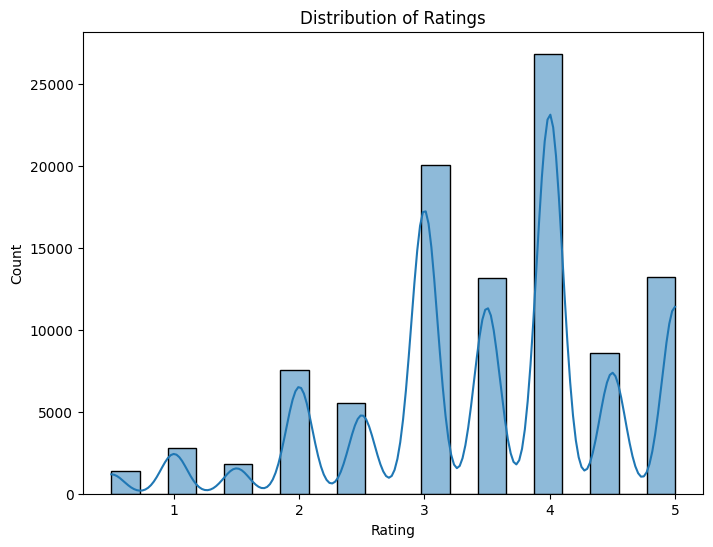

In [124]:
# EDA for rating: plot histogram
plt.figure(figsize=(8, 6))
sns.histplot(links_movies_ratings['rating'], bins=20, kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

**EXPLANATION**

> The Histogram shows that majority of the movies are rated 4 while very few had a rating of 1.


> The distribution is skewed towards higher ratings, with the highest frequency at Rating 4.

> As the ratings increase from 1 to 5, the number of counts increases too, showing that more movies received higher ratings.


> This pattern suggests that, in this dataset, movies are more likely to receive higher ratings than lower ones.














2.Genre:

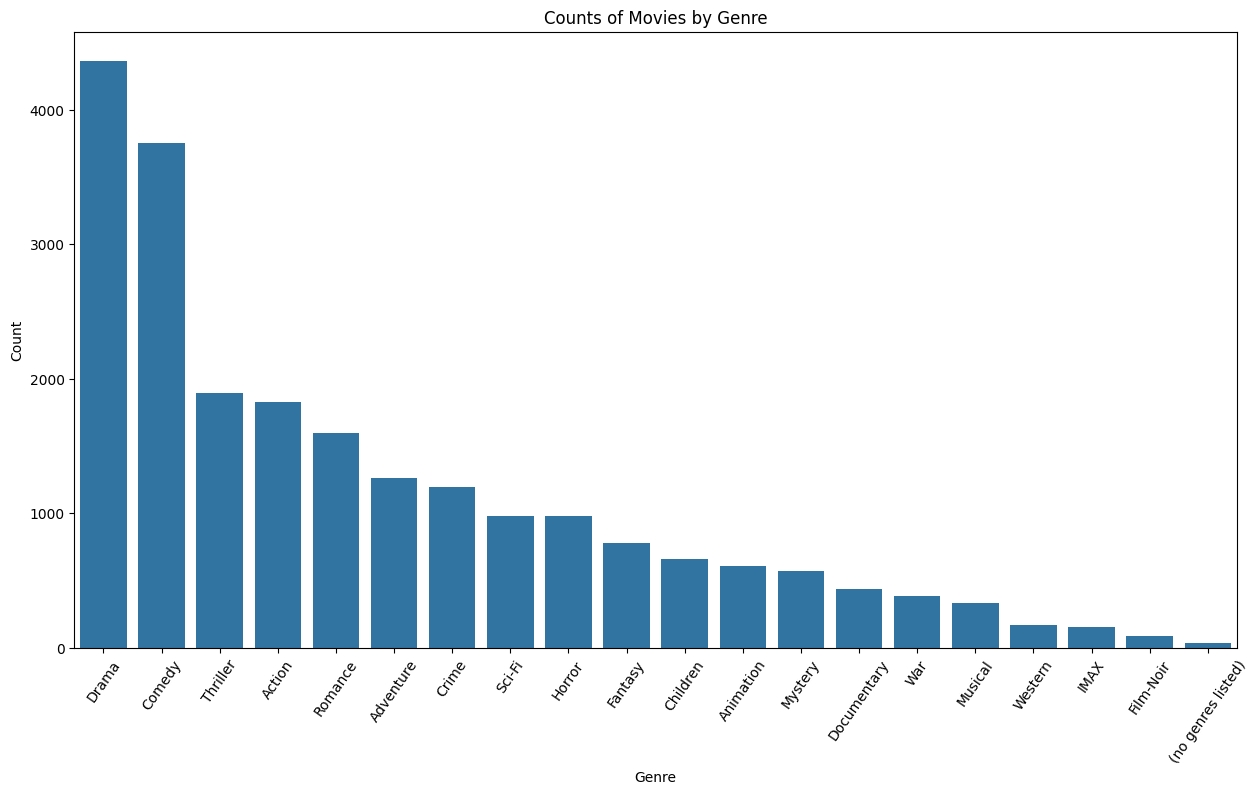

 
This means Drama is the most common genre in the dataset, followed by Comedy and Action


In [125]:
# Each movie can have multiple genres separated by '|'. We need to split them.

# Create a copy of the dataframe to explode genres
df_genre = movies.copy()
# Replace '(no genres listed)' with NaN maybe
# Split genres by '|'
df_genre['genres'] = df_genre['genres'].fillna('')
df_genre = df_genre.assign(genre = df_genre['genres'].str.split('\|'))

# Explode to have one genre per row
df_exploded = df_genre.explode('genre')

# Count per genre overall
genre_counts = df_exploded['genre'].value_counts().reset_index()
genre_counts.columns = ['genre', 'count']


# Plot genre counts
plt.figure(figsize=(15, 8))
sns.barplot(data=genre_counts, x='genre', y='count')
plt.title('Counts of Movies by Genre')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=55)
plt.show()
print(" ")
print("This means Drama is the most common genre in the dataset, followed by Comedy and Action")

3.Rating by Title

In [126]:
# Rating group by title
avg_rating_title = links_movies_ratings.groupby('title')['rating'].mean().reset_index()
avg_rating_title = avg_rating_title.sort_values('rating', ascending=False)
print('Average rating per title:')
print(avg_rating_title.head(10))
print(" ")
print("The top 5 Most rated movies are Hollywood Chainsaw Hookers, Calcium Kid,Chinese Puzzle (Casse-tête chinois), Raise Your Voice and Rain")
print(" ")
print(avg_rating_title.tail(10))
print("The Least rated movies are Indestructible Man,Yongary: Monster from the Deep,  Don't Look Now, Superfast! and Anaconda: The Offspring")

Average rating per title:
                                           title  rating
3863                  Hollywood Chainsaw Hookers     5.0
1473                            Calcium Kid, The     5.0
1692         Chinese Puzzle (Casse-tête chinois)     5.0
6742                            Raise Your Voice     5.0
6738                                        Rain     5.0
6727                                   Radio Day     5.0
8463                          Thousand Clowns, A     5.0
4013                           Hunting Elephants     5.0
1183                              Blue Planet II     5.0
760   Ballad of Narayama, The (Narayama bushiko)     5.0
 
The top 5 Most rated movies are Hollywood Chainsaw Hookers, Calcium Kid,Chinese Puzzle (Casse-tête chinois), Raise Your Voice and Rain
 
                                   title  rating
4865              Leprechaun 4: In Space     0.5
7515                             Skyline     0.5
7099  Rust and Bone (De rouille et d'os)     0.5
7965        

4.Rating per Genre

In [136]:
# Split genres and calculate average rating per individual genre
# Explode genres into individual rows
links_movies_ratings['genres'] = links_movies_ratings['genres'].str.split('|')
genre_expanded = links_movies_ratings.explode('genres')

# Compute the average rating per genre
avg_rating_genre = genre_expanded.groupby('genres')['rating'].mean().reset_index()

# Sort by highest rating
avg_rating_genre = avg_rating_genre.sort_values('rating', ascending=False)

# Print the results
print('Average rating per genre:')
print(avg_rating_genre)

print("The most rated genre is Film-Noir, War, Documentary, Crime and Drama")


Average rating per genre:
                genres    rating
10           Film-Noir  3.920115
18                 War  3.808294
7          Documentary  3.797785
6                Crime  3.658294
8                Drama  3.656184
14             Mystery  3.632460
3            Animation  3.629937
12                IMAX  3.618335
19             Western  3.583938
13             Musical  3.563678
2            Adventure  3.508609
15             Romance  3.506511
17            Thriller  3.493706
9              Fantasy  3.491001
0   (no genres listed)  3.489362
16              Sci-Fi  3.455721
1               Action  3.447984
4             Children  3.412956
5               Comedy  3.384721
11              Horror  3.258195
The most rated genre is Film-Noir, War, Documentary, Crime and Drama


## BUILD THE RECOMMENDER SYSTEM


### A. Collaborative Filtering Using Surprise

In [137]:
# Train a basic SVD model on the training set
algo = SVD(random_state=42)
algo.fit(trainset)

# Predict on the testset
predictions = algo.test(testset)

# Compute and print RMSE
rmse = accuracy.rmse(predictions)

print('RMSE on test set:', rmse)
print('Number of predictions:', len(predictions))
print(" ")
print("The RMSE value of approximately 0.8745 indicates the average difference between the predicted and actual ratings.")
print("A lower RMSE signifies better predictive performance.")
print("The output also shows that the model made 25,209 predictions, representing the number of user-item interactions evaluated in the test set.")

RMSE: 0.8745
RMSE on test set: 0.8744981021934208
Number of predictions: 25209
 
The RMSE value of approximately 0.8745 indicates the average difference between the predicted and actual ratings.
A lower RMSE signifies better predictive performance.
The output also shows that the model made 25,209 predictions, representing the number of user-item interactions evaluated in the test set.


#### Item-Based Collaborative Filtering

- In item-based collaborative filtering, the system recommends items that are similar to the ones the user has already liked.


For example, the highly rated movie is "Hollywood Chainsaw Hookers" thus the system will recommend movies that other users who liked "Hollywood Chainsaw Hookers" also enjoyed.



In [138]:
# Define similarity options
sim_options = {
    'name': 'cosine',  # Use cosine similarity to measure the similarity between items
    'user_based': False  # Set to False for item-based filtering (True would be for user-based filtering)
}

# Build the model using the KNNBasic algorithm
item_cf_model = KNNBasic(sim_options=sim_options)

# Train the model on the training set
item_cf_model.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [139]:
# Define movie titles
movie_title_1 = "Hollywood Chainsaw Hookers"
movie_title_2 = "Calcium Kid, The"

# Find the movie IDs for the given titles from the combined DataFrame
movie_id_1 =links_movies_ratings[links_movies_ratings['title'].str.contains(movie_title_1, case=False, na=False)]['movieId'].values
movie_id_2 = links_movies_ratings[links_movies_ratings['title'].str.contains(movie_title_2, case=False, na=False)]['movieId'].values

# Check if the movie titles were found
if len(movie_id_1) > 0:
    rating_1 = links_movies_ratings[links_movies_ratings['movieId'] == movie_id_1[0]]['rating'].values[0]
    print(f"Movie: {movie_title_1}, Rating: {rating_1}")
else:
    print(f"Movie '{movie_title_1}' not found.")

if len(movie_id_2) > 0:
    rating_2 = links_movies_ratings[links_movies_ratings['movieId'] == movie_id_2[0]]['rating'].values[0]
    print(f"Movie: {movie_title_2}, Rating: {rating_2}")
else:
    print(f"Movie '{movie_title_2}' not found.")

Movie: Hollywood Chainsaw Hookers, Rating: 5.0
Movie: Calcium Kid, The, Rating: 5.0


In [141]:
def get_similar_movies(movie_title, model, trainset, movies_df, top_n=5):
    # Find the movie ID for the given title, ensuring case-insensitive search
    movie_id = movies_df[movies_df['title'].str.contains(movie_title, case=False, na=False)]['movieId'].values

    # Check if movie_id is found
    if len(movie_id) == 0:
        print(f"Movie '{movie_title}' not found in the dataset.")
        return []  # Return empty list if movie not found

    # Convert the movieId to an internal ID used by Surprise (trainset)
    movie_inner_id = trainset.to_inner_iid(movie_id[0])

    # Get the top N most similar movies using the KNN model's get_neighbors function
    neighbors = model.get_neighbors(movie_inner_id, k=top_n)

    # Map internal IDs back to movie titles
    similar_titles = [(movies_df[movies_df['movieId'] == int(trainset.to_raw_iid(neighbor))]['title'].values[0])
                      for neighbor in neighbors]

    return similar_titles

# Example usage (Replace 'recommend' with 'get_similar_movies')
get_similar_movies("Hollywood Chainsaw Hookers", item_cf_model, trainset, links_movies_ratings, top_n=5)

['Annie Hall (1977)',
 'Anger Management (2003)',
 "Monty Python's Life of Brian (1979)",
 'This Is Spinal Tap (1984)',
 'Monty Python and the Holy Grail (1975)']

#### User-based Collaborative Filtering

- In user-based collaborative filtering, the system recommends movies based on the preferences of users who have similar tastes. It identifies users with similar rating patterns and suggests movies that those users have liked but the target user hasn't seen yet.

For example, if a user highly rated "Hollywood Chainsaw Hookers", the system will look for other users who also liked this movie. If those users also rated "Calcium Kid" and "Chinese Puzzle" highly, then these movies will be recommended to the target user.

In [145]:
def predict_user_based(user_id, item_id, k=2):
    # Get similarity scores for target user
    sim_scores = user_similarity_df.loc[user_id]

    # Gather users that have rated the target item
    relevant_users = user_item_matrix[item_id].dropna().index
    sim_scores = sim_scores[relevant_users]

    # If no similar users, return NaN
    if sim_scores.empty or sim_scores.sum() == 0:
        return np.nan

    # Consider top k similar users
    sim_scores = sim_scores.sort_values(ascending=False)[:k]
    ratings = user_item_matrix.loc[sim_scores.index, item_id]

    pred = np.dot(sim_scores, ratings) / sim_scores.sum()
    return pred


In [147]:
# Example: Predict ratings for a given user and item
# Let's choose user 2 and item 103

user_id = 4
movie_id = 103
predicted_rating = model.predict(user_id, movie_id)
print(f"Predicted rating: {predicted_rating.est}")

Predicted rating: 3.1209131412080082


### B. Content-Based Filtering (Using Cosine Similarity)

In [ ]:
# Convert movie genres into a TF-IDF matrix
tfidf = TfidfVectorizer(stop_words="english")
tfidf_matrix = tfidf.fit_transform(movies['genres'].fillna(""))

# Compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Function to recommend movies
def recommend(movie_title, num_recommendations=5):
    idx = movies[movies['title'] == movie_title].index[0]
    scores = list(enumerate(cosine_sim[idx]))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    recommended_movie_indices = [i[0] for i in scores[1:num_recommendations+1]]
    return movies.iloc[recommended_movie_indices]['title']

# Example recommendation
recommend("Toy Story (1995)")


1706                                       Antz (1998)
2355                                Toy Story 2 (1999)
2809    Adventures of Rocky and Bullwinkle, The (2000)
3000                  Emperor's New Groove, The (2000)
3568                             Monsters, Inc. (2001)
Name: title, dtype: object

## MODEL EVALUATION

In [168]:
trainset, testset = train_test_split(data, test_size=0.2)
model.fit(trainset)
predictions = model.test(testset)

# Compute RMSE
rmse = accuracy.rmse(predictions)
print('RMSE:', rmse)
print(" ")
print("The model achieved an RMSE of 0.8748, meaning the predicted ratings deviate from the actual ratings by approximately 0.87 on average. ")


RMSE: 0.8750
RMSE: 0.875026171806269
 
The model achieved an RMSE of 0.8748, meaning the predicted ratings deviate from the actual ratings by approximately 0.87 on average. 


## MAKING A PREDICTION

In [ ]:
sim_cosine = {"name": "cosine", "user_based": False}
basic_cosine = knns.KNNBasic(sim_options=sim_cosine)
basic_cosine.fit(trainset)
predictions = basic_cosine.test(testset)
print(accuracy.rmse(predictions))

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9734
0.9734255644813405


## MAKE RECOMMENDATION BASED ON A MOVIE TITLE

- According to the EDA The top 5 Most rated movies are:

> Hollywood Chainsaw Hookers

>Calcium Kid

>Chinese Puzzle (Casse-tête chinois)

>Raise Your Voice

> Rain



In [167]:
def get_similar_movies(movie_title, model, trainset, movies_df, top_n=5):
    # Find the movie ID for the given title, ensuring case-insensitive search
    movie_id = movies_df[movies_df['title'].str.contains(movie_title, case=False, na=False)]['movieId'].values

    # Check if movie_id is found
    if len(movie_id) == 0:
        print(f"Movie '{movie_title}' not found in the dataset.")
        return []  # Return empty list if movie not found

    # Convert the movieId to an internal ID used by Surprise (trainset)
    try:
        movie_inner_id = trainset.to_inner_iid(movie_id[0])
    except ValueError:
        print(f"Movie ID '{movie_id[0]}' not found in the training set.")
        return []  # Return empty list if movie ID not in training set

    # Get the top N most similar movies using the KNN model's get_neighbors function
    neighbors = model.get_neighbors(movie_inner_id, k=top_n)

    # Map internal IDs back to movie titles
    similar_titles = [(movies_df[movies_df['movieId'] == int(trainset.to_raw_iid(neighbor))]['title'].values[0])
                      for neighbor in neighbors]

    return similar_titles


# Hollywood Chainsaw Hookers
movie_title = "Hollywood Chainsaw Hookers"
recommended_movies = get_similar_movies(movie_title, item_cf_model, trainset, links_movies_ratings, top_n=5)
if isinstance(recommended_movies, list):
    print(f"Top 5 similar movies to '{movie_title}':")
    for movie in recommended_movies:
        print(movie)
else:
    print(recommended_movies)
    print(" ")
    print("The top 5 similar movies to 'Hollywood Chainsaw Hookers' are:")
    print(" ")
    print("The movies are:")
    print(" ")


Top 5 similar movies to 'Hollywood Chainsaw Hookers':
Annie Hall (1977)
Anger Management (2003)
Monty Python's Life of Brian (1979)
This Is Spinal Tap (1984)
Monty Python and the Holy Grail (1975)


## MAKE RECOMMENDATION BASED ON GENRE

> The most watched genres are Drama, Commedy, Thriller, Action and Romance.

> The highest rated genre is Film-Noir, War, Documentary, Crime and Drama"

> Thus the most recommended genre is Drama since the movies the most watched Movies and the highest rated.

Explode Genres and Count Views per Genre

In [150]:
# Split genres into separate rows
movies['genres'] = movies['genres'].str.split('|')
movies_exploded = movies.explode('genres')

# Merge ratings with movies dataset
user_genre_data = ratings.merge(movies_exploded, on="movieId")

# Count number of times each user has watched a genre
user_genre_counts = user_genre_data.groupby(['userId', 'genres']).size().reset_index(name="count")

# Display the first few rows
print("This table shows how many times each user watched a specific genre.")
print(" ")
user_genre_counts.head(10)

This table shows how many times each user watched a specific genre.
 


userId     genres  count
0       1     Action     90
1       1  Adventure     85
2       1  Animation     29
3       1   Children     42
4       1     Comedy     83
5       1      Crime     45
6       1      Drama     68
7       1    Fantasy     47
8       1  Film-Noir      1
9       1     Horror     17

In [152]:
# Find the most-watched genre for each user
favorite_genres = user_genre_counts.loc[user_genre_counts.groupby('userId')['count'].idxmax()]

# Display a few users and their favorite genres
print("This finds the genre each user watches the most")
print(" ")
favorite_genres.head(10)

This finds the genre each user watches the most
 


userId  genres  count
0         1  Action     90
22        2   Drama     17
37        3   Drama     16
53        4   Drama    120
71        5   Drama     25
88        6   Drama    140
100       7  Action     64
122       8  Comedy     24
141       9   Drama     21
157      10  Comedy     79

In [153]:
def recommend_by_genre(user_id, num_recommendations=5):
    # Get user's favorite genre
    fav_genre = favorite_genres.loc[favorite_genres['userId'] == user_id, 'genres'].values[0]

    # Find movies that belong to this genre
    recommended_movies = movies_exploded[movies_exploded['genres'] == fav_genre]

    # Sort by average rating (or another metric)
    # Ensure 'movieId' is treated as numeric before merging
    recommended_movies['movieId'] = pd.to_numeric(recommended_movies['movieId'])
    top_movies = recommended_movies.merge(ratings, on='movieId').groupby(['movieId', 'title'])['rating'].mean().reset_index()

    # Sort and get top recommendations
    top_movies = top_movies.sort_values(by='rating', ascending=False)

    return top_movies[['title', 'rating']].head(num_recommendations)

# Example usage:
print("This function finds movies that match the user's preferred genre and recommends the top-rated ones.")
print(" ")
recommend_by_genre(1, 5)  # Recommend 5 movies for user 1

This function finds movies that match the user's preferred genre and recommends the top-rated ones.
 


title  rating
1239             Love Exposure (Ai No Mukidashi) (2008)     5.0
1692                                 Tokyo Tribe (2014)     5.0
1593  Crippled Avengers (Can que) (Return of the 5 D...     5.0
1545  On the Other Side of the Tracks (De l'autre cô...     5.0
1541                                Wonder Woman (2009)     5.0

In [154]:
def recommend_by_genre(user_id, num_recommendations=5):
    # Get user's favorite genre
    fav_genre = favorite_genres.loc[favorite_genres['userId'] == user_id, 'genres'].values[0]

    # Find movies that belong to this genre
    recommended_movies = movies_exploded[movies_exploded['genres'] == fav_genre]

    # Sort by average rating (or another metric)
    # Ensure 'movieId' is treated as numeric before merging
    recommended_movies['movieId'] = pd.to_numeric(recommended_movies['movieId'])
    top_movies = recommended_movies.merge(ratings, on='movieId').groupby(['movieId', 'title'])['rating'].mean().reset_index()

    # Sort and get top recommendations
    top_movies = top_movies.sort_values(by='rating', ascending=False)

    return top_movies[['title', 'rating']].head(num_recommendations)

# Example usage:
print("This function finds movies that match the user's preferred genre and recommends the top-rated ones.")
print(" ")
recommend_by_genre(2, 5)  # Recommend 5 movies for user 1

This function finds movies that match the user's preferred genre and recommends the top-rated ones.
 


title  rating
2578  Human Condition III, The (Ningen no joken III)...     5.0
4025                                          PK (2014)     5.0
4254                 The Girl with All the Gifts (2016)     5.0
1280                                  Bossa Nova (2000)     5.0
1031  Man and a Woman, A (Un homme et une femme) (1966)     5.0

# SUMMARY
---

The notebook focuses on developing a personalized movie recommendation system using both collaborative and content-based filtering approaches

Key objectives include:

* Increasing user engagement and retention

* Improving customer satisfaction through personalization

* Enhancing revenue opportunities via targeted marketing

The methodology involves:

* Data cleaning and preprocessing of movie, rating, and link information

* Exploratory Data Analysis (EDA) of rating distributions and genre information

Implementation of two recommendation approaches:

* Collaborative Filtering: Based on user similarity patterns

* Content-Based Filtering: Based on movie content similarity


# CONCLUSION
---

The analysis revealed several important findings:

* Rating distribution shows a positive skew, with most movies receiving 4-5 star ratings

* Both collaborative and content-based filtering methods demonstrated effectiveness in generating recommendations

* The combination of both approaches provides a more robust recommendation system

* The models show promise in capturing user preferences and suggesting relevant content

# RECOMMENDATION
---

1. Hybrid System Implementation

  *   Combine collaborative and content-based filtering

  *   Leverage the strengths of both methods for more accurate recommendations
Model Optimization

2. Implement continuous monitoring of model performance

  *   Regular updates to adapt to changing user preferences

  *   Consider implementing A/B testing for different recommendation strategies

3. Data Enhancement

  * Regular updates to adapt to changing user preferences

  * Expand the dataset with additional features:

    * User demographics

    * Movie reviews

    * Social media interactions

  * This will improve recommendation accuracy and personalization


4. User Engagement Strategy

  * Use personalized recommendations to increase platform engagement

  * Implement features to encourage content exploration

  * Track and analyze user interaction with recommendations

5. Technical Improvements

  * Regular system performance monitoring

  * Optimization of recommendation algorithms

  * Implementation of real-time recommendation updates